In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_102733/1374276192.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [5]:
df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')

/tmp/ipykernel_102733/1062137522.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Dictionary for vessel substrings
labels_to_vessel_names = {
    "lad_stenosis": "left anterior descending (lad)",
    "dist_lad_stenosis": "distal segment of the left anterior descending (lad)",
    "mid_lad_stenosis": "mid segment of the left anterior descending (lad)",
    "lcx_stenosis": "left circumflex (lcx)",
    "dist_lcx_stenosis": "distal branch of the left circumflex (lcx)",
    "leftmain_stenosis": "left main coronary artery (lmca)",
    "prox_rca_stenosis": "proximal right coronary artery (rca)",
    "mid_rca_stenosis": "mid portion of the right coronary artery (rca)",
    "dist_rca_stenosis": "distal portion of the right coronary artery (rca)",
    "posterolateral_stenosis": "posterolateral branch",
    "pda_stenosis": "posterior descending artery (pda)",
}


def parse_report_to_numeric_stenoses(report_text, labels_map):
    parsed_dict = {lbl: None for lbl in labels_map.keys()}
    parsed_dict["coronary_dominance"] = None

    sentences = report_text.split(".")
    # Regex capturing e.g. "~70" or "(40.0" if "stenosis" is in the line
    stenosis_regex = re.compile(r"(?:~|\()?(\d+(?:\.\d+)?)")

    for sentence in sentences:
        line = sentence.strip()
        if not line:
            continue

        lower_line = line.lower()

        # Check dominance
        if "the coronary circulation is" in lower_line:
            if "right dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "right"
            elif "left dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "left"
            elif "co dominant" in lower_line or "codominant" in lower_line:
                parsed_dict["coronary_dominance"] = "co"

        # Attempt to find numeric
        match = stenosis_regex.search(line)
        if match and "stenosis" in lower_line:
            numeric_value = float(match.group(1))  # e.g. "70"
        else:
            if "free of" in lower_line and "stenosis" in lower_line:
                numeric_value = 0.0
            else:
                numeric_value = None

        if numeric_value is not None:
            # Loose matching by removing whitespace
            line_no_space = "".join(ch.lower() for ch in line if not ch.isspace())
            for lbl, vessel_substring in labels_map.items():
                vs_no_space = "".join(ch.lower() for ch in vessel_substring if not ch.isspace())
                if vs_no_space in line_no_space:
                    parsed_dict[lbl] = numeric_value

    return parsed_dict


def compute_predicted_stenoses(row, unique_texts_map, labels_map, topk=5):
    aggregated = {lbl: [] for lbl in labels_map.keys()}

    for k in range(1, topk + 1):
        col = f"predicted_idx_{k}"
        if col not in row:
            continue

        idx_val = row[col]
        if pd.isna(idx_val):
            continue

        idx_val = int(idx_val)
        if idx_val not in unique_texts_map:
            continue

        text = unique_texts_map[idx_val]
        parsed = parse_report_to_numeric_stenoses(text, labels_map)
        for lbl, val in parsed.items():
            if lbl == "coronary_dominance":
                continue
            if val is not None:
                aggregated[lbl].append(val)

    results = {}
    for lbl, vals in aggregated.items():
        if len(vals) > 0:
            results[lbl] = sum(vals) / len(vals)
        else:
            results[lbl] = None

    return results


def reverse_engineer_stenosis_predictions(predictions_csv_path, unique_texts_csv_path,
                                         labels_map, topk=5):
    df_pred = pd.read_csv(predictions_csv_path)
    df_texts = pd.read_csv(unique_texts_csv_path)
    unique_texts_map = dict(zip(df_texts["Index"], df_texts["Text"]))

    all_rows = []
    for _, row in df_pred.iterrows():
        row_stenoses = compute_predicted_stenoses(row, unique_texts_map, labels_map, topk)
        all_rows.append(row_stenoses)

    df_stenoses = pd.DataFrame(all_rows)

    # rename => predicted_X
    rename_map = {}
    for col in df_stenoses.columns:
        rename_map[col] = f"predicted_{col}"

    df_stenoses = df_stenoses.rename(columns=rename_map)

    return pd.concat([df_pred.reset_index(drop=True), df_stenoses.reset_index(drop=True)], axis=1)




# The merged_df and the plot are your final outputs

In [3]:
def plot_vessel_metrics(df_dataset, predictions_csv, unique_texts_csv, labels_to_vessel_names, topk=5):
    """
    Generate and plot vessel metrics from predictions and ground truth data.
    
    Args:
        df_dataset: DataFrame containing ground truth data with vessel stenosis columns
        predictions_csv: Path to CSV file containing model predictions
        unique_texts_csv: Path to CSV file containing unique text samples
        labels_to_vessel_names: Dictionary mapping label names to vessel names
        topk: Number of top predictions to consider (default=5)
    """
    # 1) Generate predictions with predicted_* columns
    df_predictions = reverse_engineer_stenosis_predictions(
        predictions_csv,
        unique_texts_csv,
        labels_to_vessel_names,
        topk=topk,
    )

    # 2) Merge with df_dataset on "FileName"
    merged_df = pd.merge(df_predictions, df_dataset, on="FileName", how="left")

    # 3) Compute MAE for each vessel
    vessel_labels = [
        "lad_stenosis",
        "dist_lad_stenosis", 
        "mid_lad_stenosis",
        "lcx_stenosis",
        "dist_lcx_stenosis",
        "leftmain_stenosis",
        "prox_rca_stenosis",
        "mid_rca_stenosis",
        "dist_rca_stenosis",
        "posterolateral_stenosis",
        "pda_stenosis",
    ]

    mae_values = {}
    corr_values = {}

    print("Mean Absolute Error for each vessel:")
    for lbl in vessel_labels:
        pred_col = f"predicted_{lbl}"
        if pred_col not in merged_df.columns or lbl not in merged_df.columns:
            continue

        # absolute error column
        merged_df[f"abs_error_{lbl}"] = (merged_df[pred_col] - merged_df[lbl]).abs()

        mae = merged_df[f"abs_error_{lbl}"].mean(skipna=True)
        mae_values[lbl] = mae
        print(f"  {lbl}: MAE = {mae:.2f}")

        # Pearson correlation (between predicted and actual)
        # we dropna to avoid issues
        valid_rows = merged_df[[lbl, pred_col]].dropna()
        if len(valid_rows) > 1:
            corr = valid_rows[lbl].corr(valid_rows[pred_col], method="pearson")
        else:
            corr = np.nan
        corr_values[lbl] = corr

    # Calculate averages
    avg_mae = np.mean(list(mae_values.values()))
    avg_corr = np.mean(list(corr_values.values()))
    print(f"\nAverage MAE across all vessels: {avg_mae:.2f}")
    print(f"Average correlation across all vessels: {avg_corr:.2f}")

    # 4) Show a quick bar chart of MAE and correlation
    vessels_with_data = [v for v in vessel_labels if v in mae_values]
    mae_list = [mae_values[v] for v in vessels_with_data]
    corr_list = [corr_values[v] for v in vessels_with_data]

    x_positions = np.arange(len(vessels_with_data))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar for MAE
    bar1 = ax1.bar(x_positions - width/2, mae_list, width, label="MAE", color="skyblue")
    ax1.set_ylabel("Mean Absolute Error", color="blue")
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(vessels_with_data, rotation=45, ha="right")

    # We'll create a second axis for correlation
    ax2 = ax1.twinx()
    bar2 = ax2.bar(x_positions + width/2, corr_list, width, label="Correlation", color="lightgreen")
    ax2.set_ylabel("Pearson Correlation", color="green")
    ax2.set_ylim(-1, 1)  # correlation range

    # Combine legends
    bars = [bar1, bar2]
    labels = [b.get_label() for b in bars]
    ax1.legend(bars, labels, loc="upper left")

    plt.title("MAE and Pearson Correlation by Vessel")
    plt.tight_layout()
    plt.show()

    return merged_df, mae_values, corr_values


/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250114-190320_2o5xoevj/val_epoch0.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 24.90
  dist_lad_stenosis: MAE = 7.70
  mid_lad_stenosis: MAE = 26.55
  lcx_stenosis: MAE = 21.15
  dist_lcx_stenosis: MAE = 18.75
  leftmain_stenosis: MAE = 13.26
  prox_rca_stenosis: MAE = 21.83
  mid_rca_stenosis: MAE = 20.76
  dist_rca_stenosis: MAE = 13.36
  posterolateral_stenosis: MAE = 7.50
  pda_stenosis: MAE = 11.25

Average MAE across all vessels: 17.00
Average correlation across all vessels: 0.27


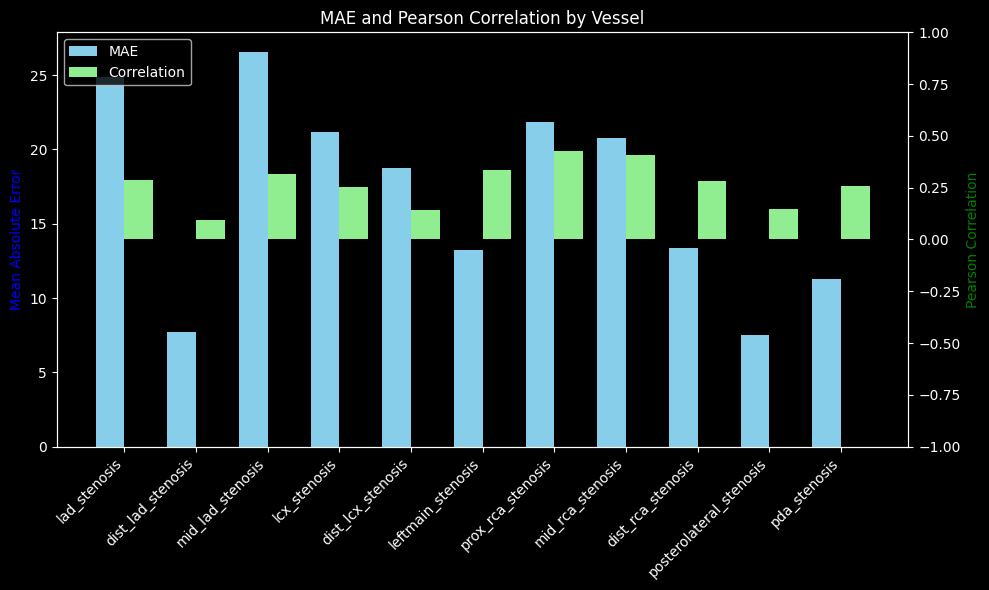

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250114-190320_2o5xoevj/val_epoch1.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 22.76
  dist_lad_stenosis: MAE = 8.10
  mid_lad_stenosis: MAE = 25.26
  lcx_stenosis: MAE = 22.56
  dist_lcx_stenosis: MAE = 20.67
  leftmain_stenosis: MAE = 12.94
  prox_rca_stenosis: MAE = 20.80
  mid_rca_stenosis: MAE = 20.10
  dist_rca_stenosis: MAE = 13.70
  posterolateral_stenosis: MAE = 7.66
  pda_stenosis: MAE = 11.40

Average MAE across all vessels: 16.91
Average correlation across all vessels: 0.28


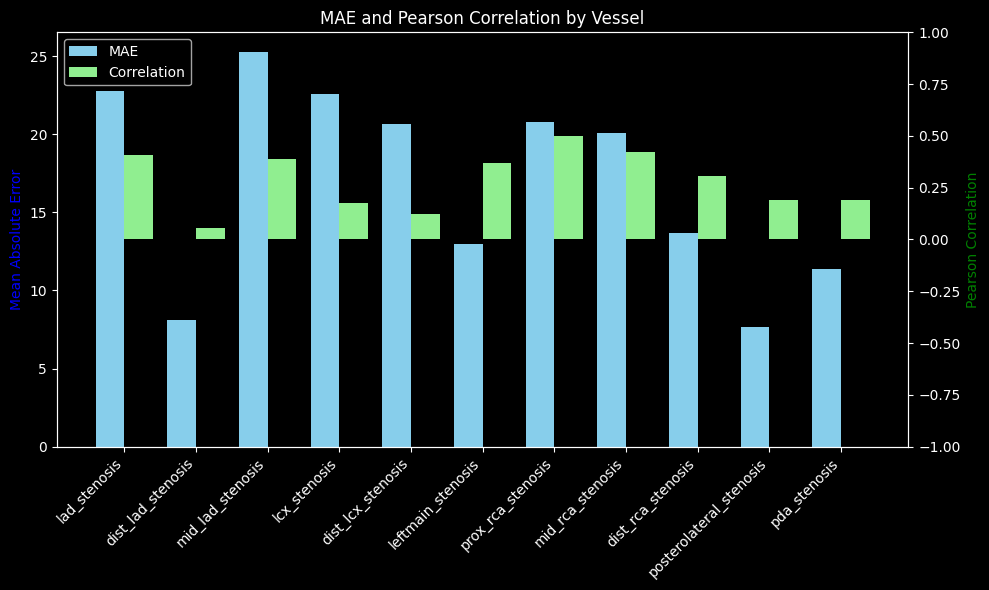

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250114-190320_2o5xoevj/val_epoch2.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 25.85
  dist_lad_stenosis: MAE = 10.00
  mid_lad_stenosis: MAE = 25.71
  lcx_stenosis: MAE = 22.81
  dist_lcx_stenosis: MAE = 21.82
  leftmain_stenosis: MAE = 15.43
  prox_rca_stenosis: MAE = 18.88
  mid_rca_stenosis: MAE = 17.85
  dist_rca_stenosis: MAE = 13.77
  posterolateral_stenosis: MAE = 8.70
  pda_stenosis: MAE = 12.56

Average MAE across all vessels: 17.58
Average correlation across all vessels: 0.31


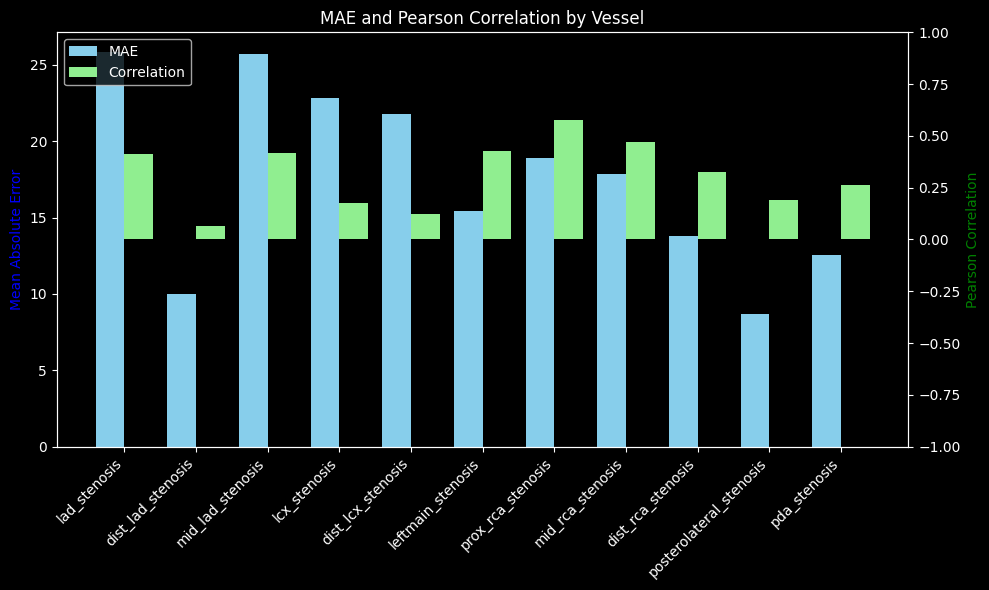

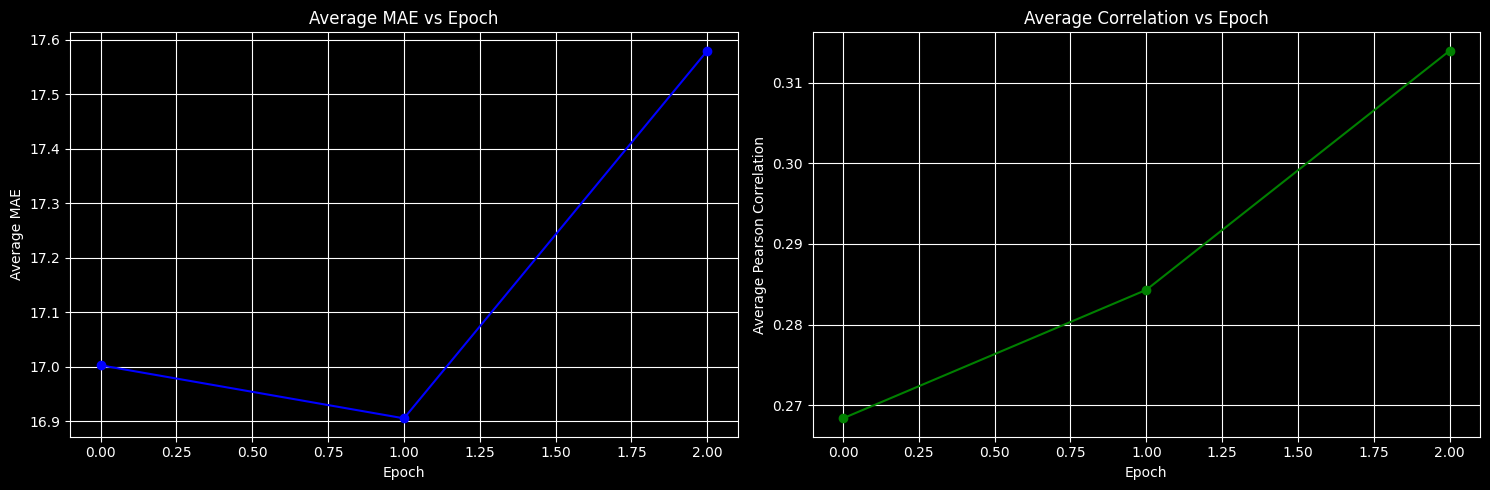

In [6]:
### Plot metrics across epochs ###
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# Get base folder path from the example path
base_folder = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250114-190320_2o5xoevj"
unique_texts_csv = os.path.join(base_folder, "unique_val_texts.csv")

# Get all val_epoch files and extract epoch numbers
val_files = glob.glob(os.path.join(base_folder, "val_epoch*.csv"))
epoch_nums = []
avg_maes = []
avg_corrs = []

for val_file in sorted(val_files, key=lambda x: int(re.findall(r'epoch(\d+)', x)[0])):
    print(val_file)
    epoch_num = int(re.findall(r'epoch(\d+)', val_file)[0])
    
    # Get metrics for this epoch
    merged_df, mae_values, corr_values = plot_vessel_metrics(
        df_dataset,
        val_file,
        unique_texts_csv,
        labels_to_vessel_names,
        topk=5
    )
    
    # Store results
    epoch_nums.append(epoch_num)
    avg_maes.append(np.mean(list(mae_values.values())))
    avg_corrs.append(np.mean(list(corr_values.values())))

# Plot metrics over epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epoch_nums, avg_maes, 'b-o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average MAE')
ax1.set_title('Average MAE vs Epoch')
ax1.grid(True)

ax2.plot(epoch_nums, avg_corrs, 'g-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Pearson Correlation')
ax2.set_title('Average Correlation vs Epoch')
ax2.grid(True)

plt.tight_layout()
plt.show()

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch0.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 26.12
  dist_lad_stenosis: MAE = 9.73
  mid_lad_stenosis: MAE = 28.86
  lcx_stenosis: MAE = 20.90
  dist_lcx_stenosis: MAE = 17.79
  leftmain_stenosis: MAE = 15.42
  prox_rca_stenosis: MAE = 21.64
  mid_rca_stenosis: MAE = 25.27
  dist_rca_stenosis: MAE = 22.99
  posterolateral_stenosis: MAE = 11.76
  pda_stenosis: MAE = 16.62

Average MAE across all vessels: 19.74
Average correlation across all vessels: 0.26


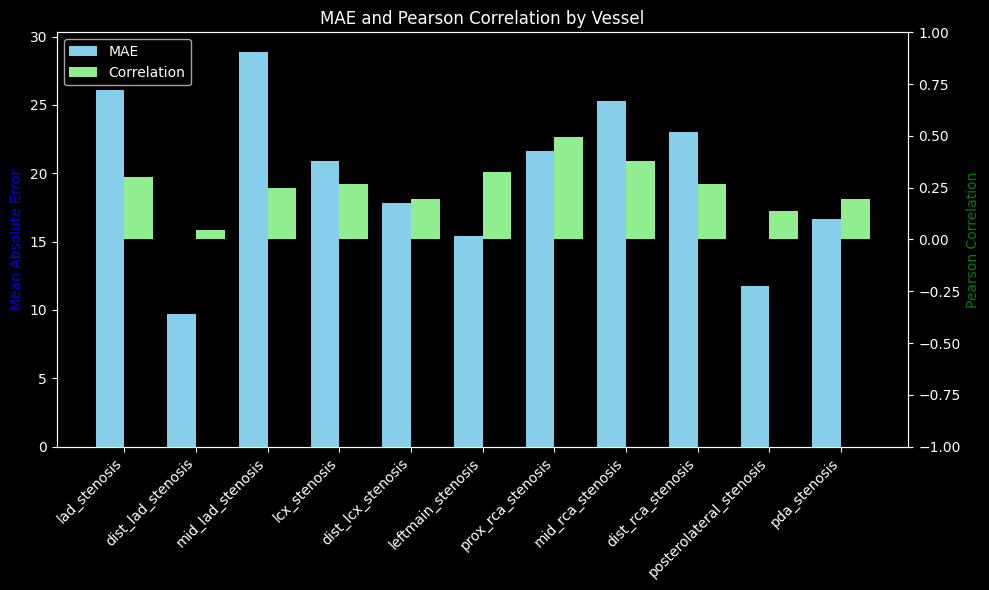

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch1.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 22.55
  dist_lad_stenosis: MAE = 8.74
  mid_lad_stenosis: MAE = 25.10
  lcx_stenosis: MAE = 20.45
  dist_lcx_stenosis: MAE = 18.73
  leftmain_stenosis: MAE = 14.61
  prox_rca_stenosis: MAE = 19.89
  mid_rca_stenosis: MAE = 18.99
  dist_rca_stenosis: MAE = 12.91
  posterolateral_stenosis: MAE = 10.55
  pda_stenosis: MAE = 12.39

Average MAE across all vessels: 16.81
Average correlation across all vessels: 0.31


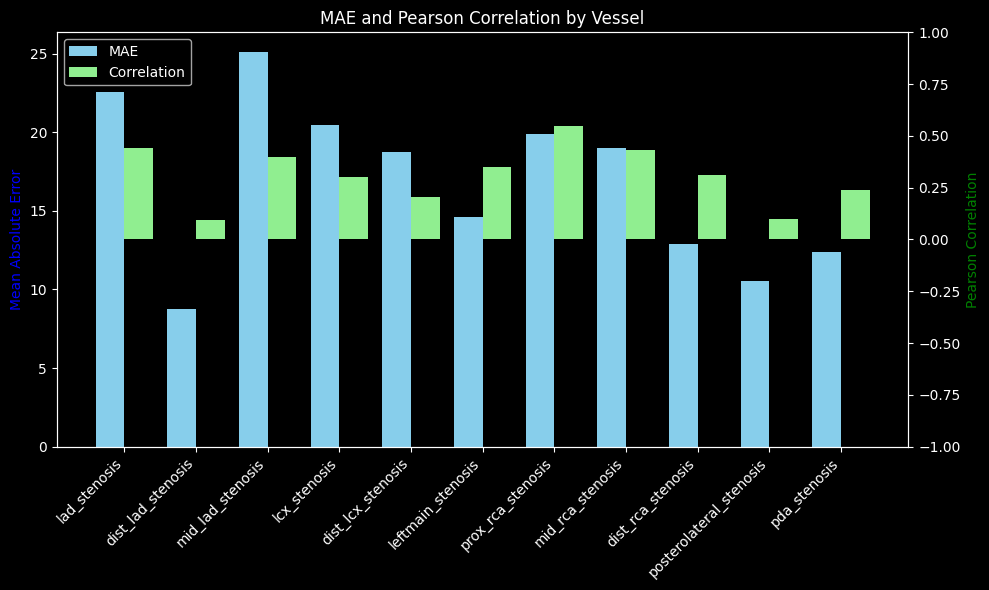

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch2.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 23.05
  dist_lad_stenosis: MAE = 8.27
  mid_lad_stenosis: MAE = 24.93
  lcx_stenosis: MAE = 21.22
  dist_lcx_stenosis: MAE = 19.41
  leftmain_stenosis: MAE = 14.42
  prox_rca_stenosis: MAE = 19.53
  mid_rca_stenosis: MAE = 19.24
  dist_rca_stenosis: MAE = 13.96
  posterolateral_stenosis: MAE = 8.24
  pda_stenosis: MAE = 12.02

Average MAE across all vessels: 16.76
Average correlation across all vessels: 0.31


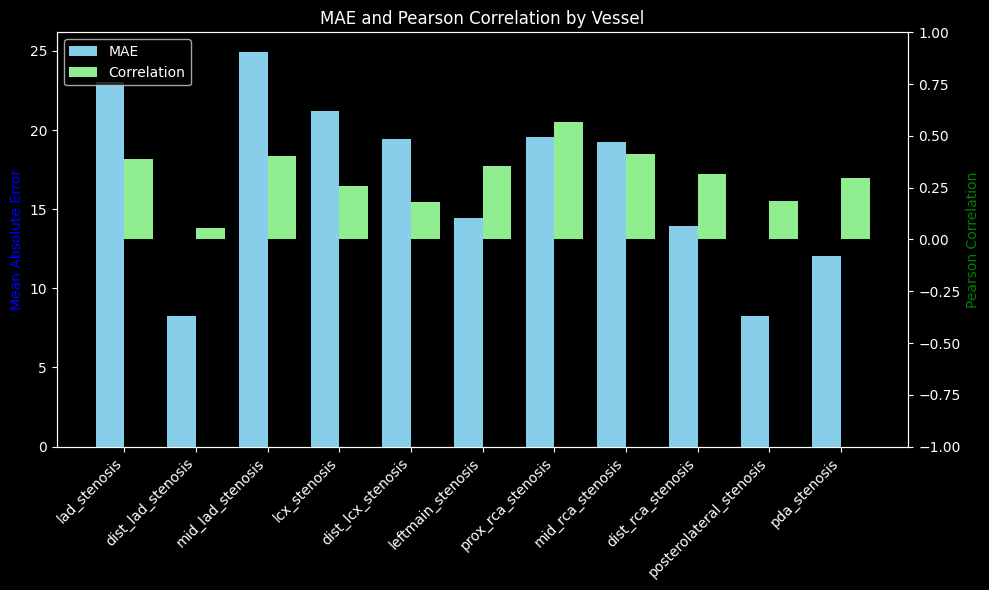

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch3.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 24.61
  dist_lad_stenosis: MAE = 9.09
  mid_lad_stenosis: MAE = 25.24
  lcx_stenosis: MAE = 20.94
  dist_lcx_stenosis: MAE = 18.49
  leftmain_stenosis: MAE = 12.47
  prox_rca_stenosis: MAE = 18.89
  mid_rca_stenosis: MAE = 18.49
  dist_rca_stenosis: MAE = 11.88
  posterolateral_stenosis: MAE = 7.28
  pda_stenosis: MAE = 10.40

Average MAE across all vessels: 16.16
Average correlation across all vessels: 0.32


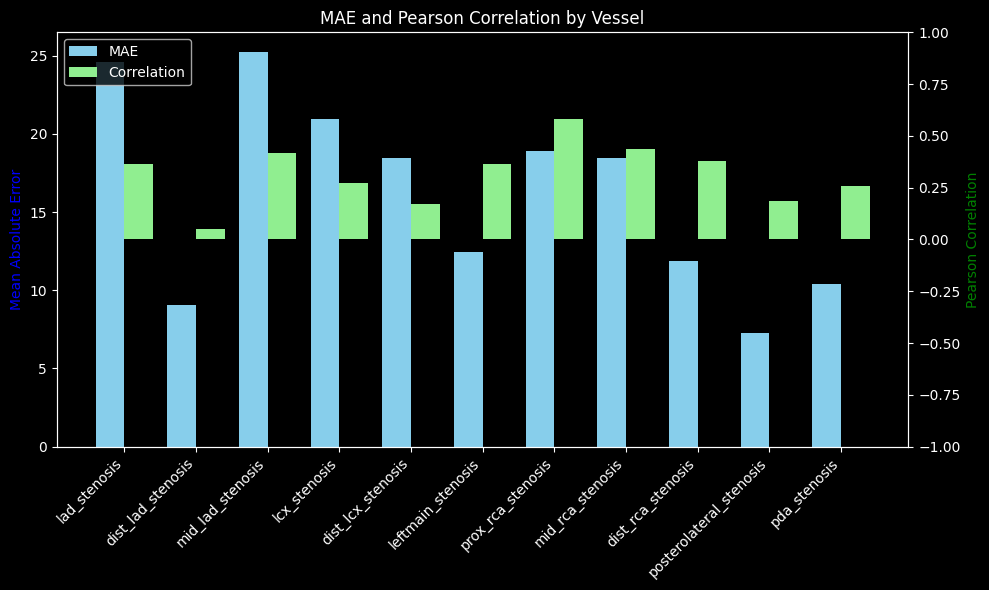

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch4.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 22.84
  dist_lad_stenosis: MAE = 8.69
  mid_lad_stenosis: MAE = 23.89
  lcx_stenosis: MAE = 20.95
  dist_lcx_stenosis: MAE = 19.35
  leftmain_stenosis: MAE = 12.93
  prox_rca_stenosis: MAE = 19.12
  mid_rca_stenosis: MAE = 18.17
  dist_rca_stenosis: MAE = 11.00
  posterolateral_stenosis: MAE = 7.26
  pda_stenosis: MAE = 10.40

Average MAE across all vessels: 15.87
Average correlation across all vessels: 0.35


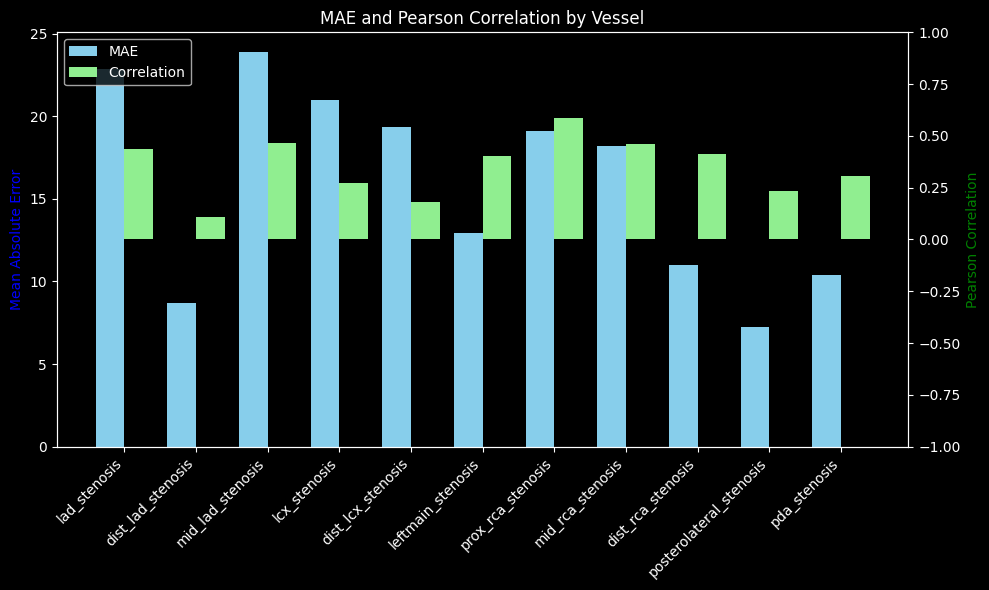

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch5.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 23.15
  dist_lad_stenosis: MAE = 9.34
  mid_lad_stenosis: MAE = 23.98
  lcx_stenosis: MAE = 20.27
  dist_lcx_stenosis: MAE = 18.73
  leftmain_stenosis: MAE = 13.05
  prox_rca_stenosis: MAE = 18.94
  mid_rca_stenosis: MAE = 18.76
  dist_rca_stenosis: MAE = 12.12
  posterolateral_stenosis: MAE = 7.79
  pda_stenosis: MAE = 11.62

Average MAE across all vessels: 16.16
Average correlation across all vessels: 0.35


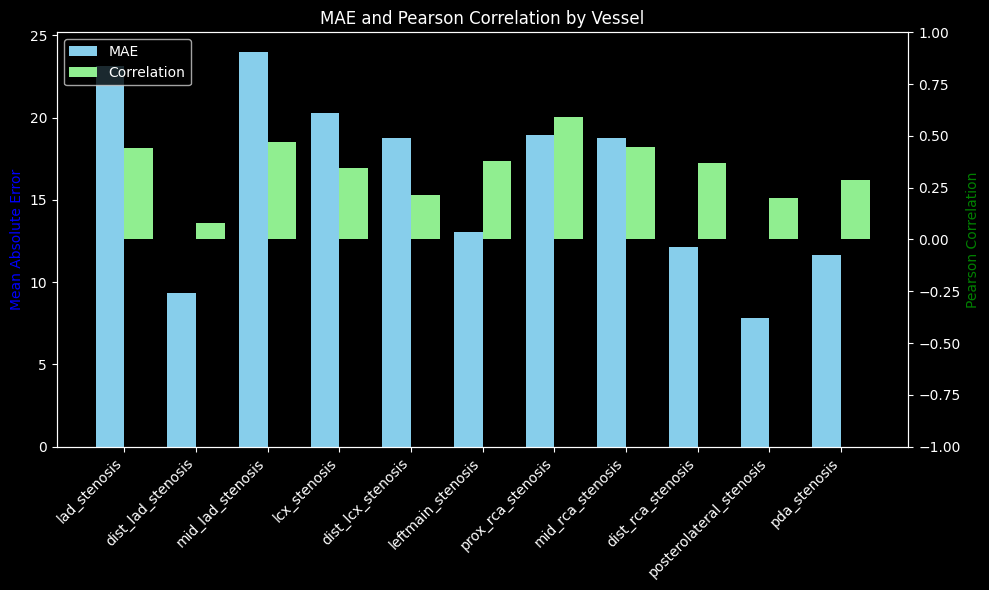

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch6.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 22.12
  dist_lad_stenosis: MAE = 8.46
  mid_lad_stenosis: MAE = 23.73
  lcx_stenosis: MAE = 21.39
  dist_lcx_stenosis: MAE = 19.52
  leftmain_stenosis: MAE = 13.39
  prox_rca_stenosis: MAE = 18.38
  mid_rca_stenosis: MAE = 18.61
  dist_rca_stenosis: MAE = 12.71
  posterolateral_stenosis: MAE = 8.24
  pda_stenosis: MAE = 12.10

Average MAE across all vessels: 16.24
Average correlation across all vessels: 0.36


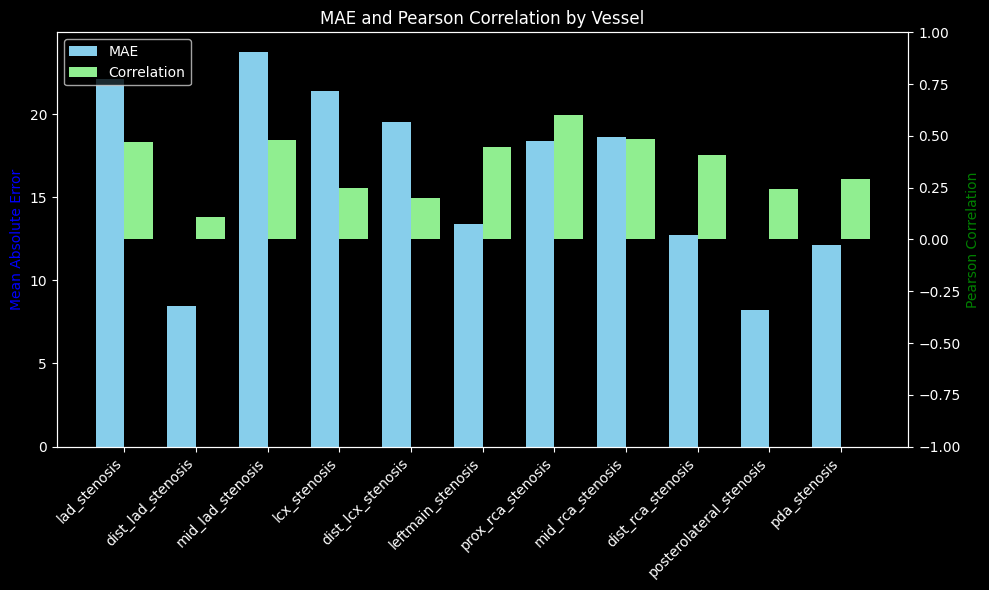

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch7.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 23.82
  dist_lad_stenosis: MAE = 9.24
  mid_lad_stenosis: MAE = 24.67
  lcx_stenosis: MAE = 20.94
  dist_lcx_stenosis: MAE = 20.25
  leftmain_stenosis: MAE = 14.83
  prox_rca_stenosis: MAE = 20.13
  mid_rca_stenosis: MAE = 20.96
  dist_rca_stenosis: MAE = 12.57
  posterolateral_stenosis: MAE = 8.03
  pda_stenosis: MAE = 11.94

Average MAE across all vessels: 17.03
Average correlation across all vessels: 0.34


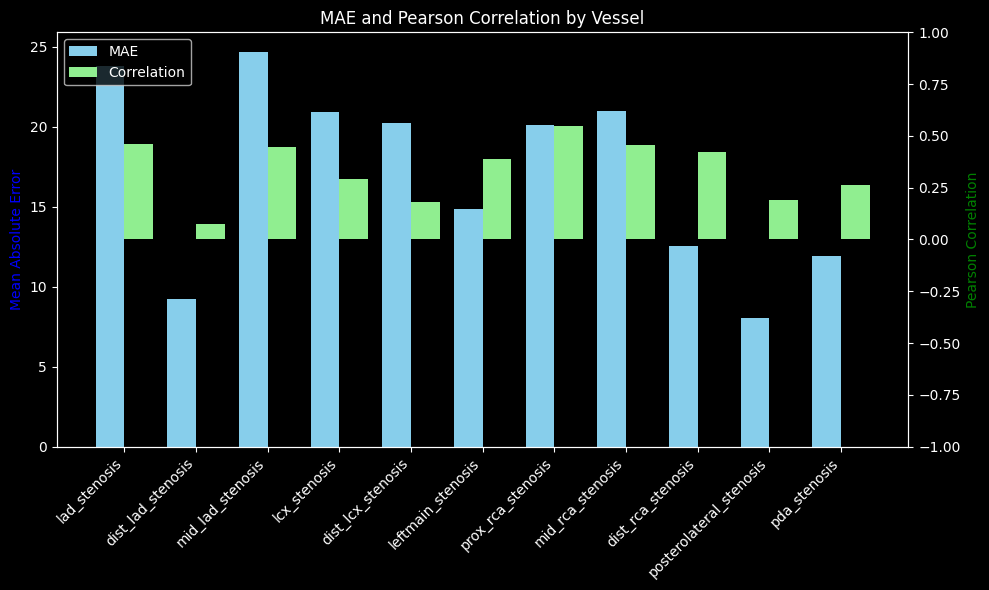

/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/val_epoch8.csv
Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 22.06
  dist_lad_stenosis: MAE = 8.73
  mid_lad_stenosis: MAE = 23.95
  lcx_stenosis: MAE = 20.58
  dist_lcx_stenosis: MAE = 18.47
  leftmain_stenosis: MAE = 13.18
  prox_rca_stenosis: MAE = 18.64
  mid_rca_stenosis: MAE = 18.04
  dist_rca_stenosis: MAE = 10.65
  posterolateral_stenosis: MAE = 7.54
  pda_stenosis: MAE = 10.83

Average MAE across all vessels: 15.70
Average correlation across all vessels: 0.36


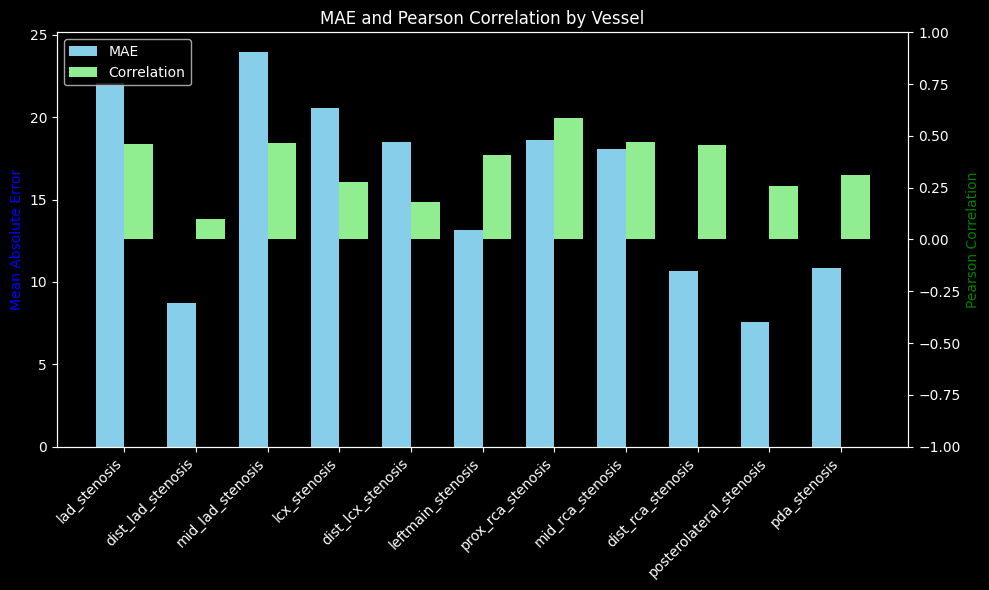

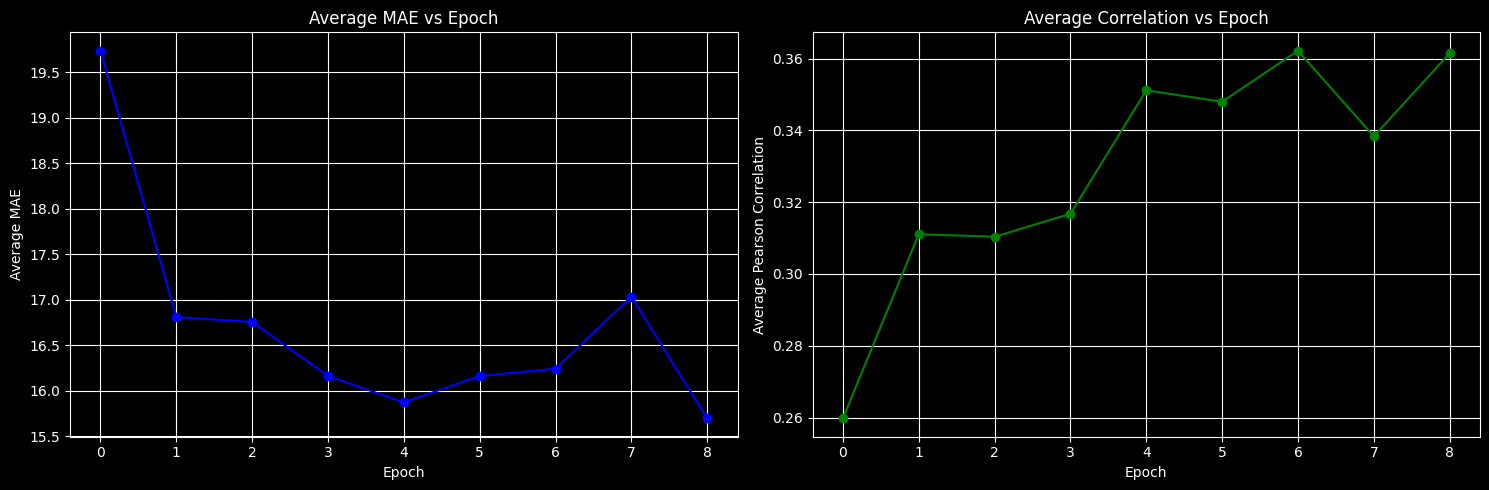

In [9]:

### Plot metrics across epochs ###
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# Get base folder path from the example path
base_folder = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250105-140102_4prjnaxn/"
unique_texts_csv = os.path.join(base_folder, "unique_val_texts.csv")

# Get all val_epoch files and extract epoch numbers
val_files = glob.glob(os.path.join(base_folder, "val_epoch*.csv"))
epoch_nums = []
avg_maes = []
avg_corrs = []

for val_file in sorted(val_files, key=lambda x: int(re.findall(r'epoch(\d+)', x)[0])):
    print(val_file)
    epoch_num = int(re.findall(r'epoch(\d+)', val_file)[0])
    
    # Get metrics for this epoch
    merged_df, mae_values, corr_values = plot_vessel_metrics(
        df_dataset,
        val_file,
        unique_texts_csv,
        labels_to_vessel_names,
        topk=5
    )
    
    # Store results
    epoch_nums.append(epoch_num)
    avg_maes.append(np.mean(list(mae_values.values())))
    avg_corrs.append(np.mean(list(corr_values.values())))

# Plot metrics over epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epoch_nums, avg_maes, 'b-o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average MAE')
ax1.set_title('Average MAE vs Epoch')
ax1.grid(True)

ax2.plot(epoch_nums, avg_corrs, 'g-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Pearson Correlation')
ax2.set_title('Average Correlation vs Epoch')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

# Calculate mean stenosis values for validation set
val_means = df_dataset[df_dataset['Split'] == 'val'][labels_to_vessel_names.keys()].mean()

# Create DataFrame with validation data
val_df = df_dataset[df_dataset['Split'] == 'val']

# Initialize dictionaries to store metrics
mae_values = {}
corr_values = {}

print("Baseline metrics using mean prediction:")
print("\nMean Absolute Error for each vessel:")

# Calculate MAE and correlation for each vessel
for vessel in labels_to_vessel_names.keys():
    # Calculate MAE
    mae = (val_df[vessel] - val_means[vessel]).abs().mean()
    mae_values[vessel] = mae
    
    # Calculate correlation
    corr = val_df[vessel].corr(pd.Series([val_means[vessel]] * len(val_df)), method='pearson')
    corr_values[vessel] = corr
    
    print(f"  {vessel}:")
    print(f"    MAE = {mae:.2f}")
    print(f"    Correlation = {corr:.2f}")
    print(f"    Mean prediction value = {val_means[vessel]:.2f}")

# Calculate and print averages
avg_mae = np.mean(list(mae_values.values()))
avg_corr = np.mean(list(corr_values.values()))
print(f"\nOverall metrics:")
print(f"Average MAE across all vessels: {avg_mae:.2f}")
print(f"Average correlation across all vessels: {avg_corr:.2f}")

# Visualization
vessels = list(labels_to_vessel_names.keys())
mae_list = [mae_values[v] for v in vessels]
corr_list = [corr_values[v] for v in vessels]

x_positions = np.arange(len(vessels))
width = 0.4

fig, ax1 = plt.subplots(figsize=(15, 5))

# Bar for MAE
bar1 = ax1.bar(x_positions - width/2, mae_list, width, label="MAE", color="skyblue")
ax1.set_ylabel("Mean Absolute Error", color="blue")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(vessels, rotation=45, ha="right")

# Second axis for correlation
ax2 = ax1.twinx()
bar2 = ax2.bar(x_positions + width/2, corr_list, width, label="Correlation", color="lightgreen")
ax2.set_ylabel("Pearson Correlation", color="green")
ax2.set_ylim(-1, 1)

# Combine legends
bars = [bar1, bar2]
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc="upper left")

plt.title("Baseline Performance: MAE and Pearson Correlation by Vessel")
plt.tight_layout()
plt.show()